# Simulating an All-Pass Filter

A simple comparison between an analytical evaluation of an all pass filter and using SAX.

## Imports

In [2]:
import tqdm
import matplotlib.pyplot as plt

import sax
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as opt

/home/jmatres/miniconda3/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


## Schematic

```
          in0---out0
       in1          out1
          \        /
           ========
          /        \
in0 <- in0          out0 -> out0

```

## Simulation & Design Parameters

In [5]:
loss = 0.1  # [dB/μm] (alpha) waveguide loss
neff = 2.34  # Effective index of the waveguides
ng = 3.4  # Group index of the waveguides
wl0 = 1.55  # [μm] the wavelength at which neff and ng are defined
ring_length = 10.0  # [μm] Length of the ring
coupling = 0.5  # [] coupling of the coupler
wl = jnp.linspace(1.5, 1.6, 1000)  # [μm] Wavelengths to sweep over

## Frequency Domain Analytically

As a comparison, we first calculate the frequency domain response for the all-pass filter analytically:

In [6]:
def all_pass_analytical():
    """ Analytic Frequency Domain Response of an all pass filter """
    detected = jnp.zeros_like(wl)
    transmission = 1 - coupling
    neff_wl = neff + (wl0 - wl) * (ng - neff) / wl0  # we expect a linear behavior with respect to wavelength
    out = jnp.sqrt(transmission) - 10 ** (-loss * ring_length / 20.0) * jnp.exp(2j * jnp.pi * neff_wl * ring_length / wl)
    out /= 1 - jnp.sqrt(transmission) * 10 ** (-loss * ring_length / 20.0) * jnp.exp(2j * jnp.pi * neff_wl * ring_length / wl)
    detected = abs(out) ** 2
    return detected


CPU times: user 183 ms, sys: 11 ms, total: 194 ms
Wall time: 189 ms
CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 39 ms
CPU times: user 29 µs, sys: 27 µs, total: 56 µs
Wall time: 59.8 µs


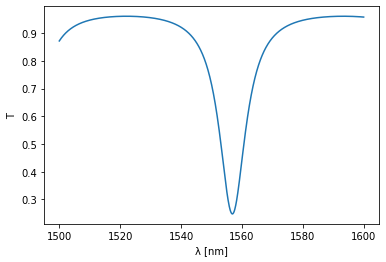

In [7]:
%time detected = all_pass_analytical() # non-jitted evaluation time
all_pass_analytical_jitted = jax.jit(all_pass_analytical)
%time detected = all_pass_analytical_jitted() # time to jit
%time detected = all_pass_analytical_jitted() # evaluation time after jitting

plt.plot(wl * 1e3, detected)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

## Scatter Dictionaries


In [9]:
all_pass_sax = sax.circuit(
    instances={
        "dc": sax.partial(sax.models.coupler, coupling=coupling),
        "top": sax.partial(sax.models.straight, length=ring_length, loss=loss, neff=neff, ng=ng, wl0=wl0, wl=wl),
    },
    connections={
        "dc:out1": "top:in0",
        "top:out0": "dc:in1",
    },
    ports={
        "in0": "dc:in0",
        "out0": "dc:out0",
    },
)

CPU times: user 962 ms, sys: 18 ms, total: 980 ms
Wall time: 962 ms
CPU times: user 92 µs, sys: 56 µs, total: 148 µs
Wall time: 104 µs
CPU times: user 30 µs, sys: 19 µs, total: 49 µs
Wall time: 52.7 µs


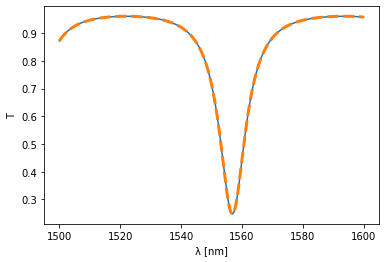

In [10]:
%time detected_sax = all_pass_sax() # non-jitted evaluation time
all_pass_sax_jitted = jax.jit(all_pass_analytical)
%time detected_sax = all_pass_sax_jitted() # time to jit
%time detected_sax = all_pass_sax_jitted() # time after jitting

plt.plot(wl * 1e3, detected, label="analytical")
plt.plot(wl * 1e3, detected_sax, label="sax", ls="--", lw=3)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()